## Methods for Pre - traininig
    - Goal is to make various data that are represented in nature
    - Methods that is used are some Synthesize, Oversampling, Variational Encoder.

### CTGAN
    - 6만개 데이터 생성
    - sampling 500개

In [3]:
import os

import pandas as pd
import numpy as np

import torch
import torch.nn as nn

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (8, 6)

import warnings
warnings.filterwarnings('ignore')

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [2]:
base_path = "heg_sample_data.csv"

heg_meta = pd.read_csv(base_path)

heg_meta = heg_meta.drop(columns=['Unnamed: 0'], errors='ignore')

In [3]:
# preprocessing
    
data_class0 = heg_meta[heg_meta['outcome'] == 0]
data_class1 = heg_meta[heg_meta['outcome'] == 1]

print(data_class0['outcome'].value_counts())
"""train_data, test_data = train_test_split(
    heg_meta, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=1024, 
    stratify=heg_meta['outcome']
)"""

outcome
0.0    11970
Name: count, dtype: int64


"train_data, test_data = train_test_split(\n    heg_meta, \n    train_size=0.8, \n    test_size=0.2, \n    random_state=1024, \n    stratify=heg_meta['outcome']\n)"

In [10]:
#test_data.to_csv("Test_data.csv", index = False)

In [4]:
##Make Class 0 dataset.

N_CLS_PER_GEN = 30000

# 모든 Fraud_Type 목록 생성 (m 포함)
modality = data_class0['outcome'].unique()

# 모든 합성 데이터를 저장할 DataFrame 초기화
all_synthetic_data0 = pd.DataFrame()

N_SAMPLE = 1000

for classes in tqdm(modality):
    if classes == 0:
        N_SAMPLE = 2000
        
    # 해당 Fraud_Type에 대한 서브셋 생성
    subset = data_class0[data_class0["outcome"] == classes]

    # 모든 Fraud_Type에 대해 1000개씩 샘플링
    subset = subset.sample(n=N_SAMPLE, random_state=42)

    # 메타데이터 생성 및 모델 학습
    metadata = SingleTableMetadata()

    metadata.detect_from_dataframe(subset)
    metadata.set_primary_key(None)

    column_sdtypes = {
        "days_from_entrance": "numerical",
        "age": "numerical",
        "document.sexo": "categorical",
        "UTI": "categorical",
        "delta_collect_timestamp_t-t1": "numerical",
        "delta_collect_timestamp_t1-t2": "numerical",
        "delta_collect_timestamp_t2-t3": "numerical",
        "delta_collect_timestamp_t3-t4": "numerical",
        "document.freq_cardiaca(t)": "numerical",
        "document.freq_cardiaca(t-1)": "numerical",
        "document.freq_cardiaca(t-2)": "numerical",
        "document.freq_cardiaca(t-3)": "numerical",
        "document.freq_cardiaca(t-4)": "numerical",
        "document.freq_respiratoria(t)": "numerical",
        "document.freq_respiratoria(t-1)": "numerical",
        "document.freq_respiratoria(t-2)": "numerical",
        "document.freq_respiratoria(t-3)": "numerical",
        "document.freq_respiratoria(t-4)": "numerical",
        "document.glicemia_capilar(t)": "numerical",
        "document.glicemia_capilar(t-1)": "numerical",
        "document.glicemia_capilar(t-2)": "numerical",
        "document.glicemia_capilar(t-3)": "numerical",
        "document.glicemia_capilar(t-4)": "numerical",
        "document.pa_diastolica(t)": "numerical",
        "document.pa_diastolica(t-1)": "numerical",
        "document.pa_diastolica(t-2)": "numerical",
        "document.pa_diastolica(t-3)": "numerical",
        "document.pa_diastolica(t-4)": "numerical",
        "document.pa_sistolica(t)": "numerical",
        "document.pa_sistolica(t-1)": "numerical",
        "document.pa_sistolica(t-2)": "numerical",
        "document.pa_sistolica(t-3)": "numerical",
        "document.pa_sistolica(t-4)": "numerical",
        "document.sat_o2(t)": "numerical",
        "document.sat_o2(t-1)": "numerical",
        "document.sat_o2(t-2)": "numerical",
        "document.sat_o2(t-3)": "numerical",
        "document.sat_o2(t-4)": "numerical",
        "document.temperatura(t)": "numerical",
        "document.temperatura(t-1)": "numerical",
        "document.temperatura(t-2)": "numerical",
        "document.temperatura(t-3)": "numerical",
        "document.temperatura(t-4)": "numerical",
        "delta_document.freq_cardiaca_t-t1": "numerical",
        "delta_document.freq_cardiaca_t1-t2": "numerical",
        "delta_document.freq_cardiaca_t2-t3": "numerical",
        "delta_document.freq_cardiaca_t3-t4": "numerical",
        "delta_document.freq_respiratoria_t-t1": "numerical",
        "delta_document.freq_respiratoria_t1-t2": "numerical",
        "delta_document.freq_respiratoria_t2-t3": "numerical",
        "delta_document.freq_respiratoria_t3-t4": "numerical",
        "delta_document.glicemia_capilar_t-t1": "numerical",
        "delta_document.glicemia_capilar_t1-t2": "numerical",
        "delta_document.glicemia_capilar_t2-t3": "numerical",
        "delta_document.glicemia_capilar_t3-t4": "numerical",
        "delta_document.pa_diastolica_t-t1": "numerical",
        "delta_document.pa_diastolica_t1-t2": "numerical",
        "delta_document.pa_diastolica_t2-t3": "numerical",
        "delta_document.pa_diastolica_t3-t4": "numerical",
        "delta_document.pa_sistolica_t-t1": "numerical",
        "delta_document.pa_sistolica_t1-t2": "numerical",
        "delta_document.pa_sistolica_t2-t3": "numerical",
        "delta_document.pa_sistolica_t3-t4": "numerical",
        "delta_document.sat_o2_t-t1": "numerical",
        "delta_document.sat_o2_t1-t2": "numerical",
        "delta_document.sat_o2_t2-t3": "numerical",
        "delta_document.sat_o2_t3-t4": "numerical",
        "delta_document.temperatura_t-t1": "numerical",
        "delta_document.temperatura_t1-t2": "numerical",
        "delta_document.temperatura_t2-t3": "numerical",
        "delta_document.temperatura_t3-t4": "numerical",
        "outcome": "categorical"
    }

    # 각 컬럼에 대해 데이터 타입 설정
    for column, sdtype in column_sdtypes.items():
        metadata.update_column(
            column_name=column,
            sdtype=sdtype
        )

    synthesizer = CTGANSynthesizer(
                            metadata,
                            epochs=500,
                        )
    synthesizer.fit(subset)

    synthetic_subset = synthesizer.sample(num_rows=N_CLS_PER_GEN)

    # 생성된 데이터를 all_synthetic_data에 추가
    all_synthetic_data_class0 = pd.concat([all_synthetic_data0, synthetic_subset], ignore_index=True)

# 최종 결과 확인
print("\nFinal All Synthetic Data Shape:", all_synthetic_data_class0.shape)
all_synthetic_data_class0.head()
all_synthetic_data_class0.to_csv("class0_data.csv", index = False)

100%|██████████| 1/1 [07:24<00:00, 444.82s/it]



Final All Synthetic Data Shape: (30000, 72)


In [5]:
##Make Class 0 dataset.

N_CLS_PER_GEN = 30000

# 모든 Fraud_Type 목록 생성 (m 포함)
modality = data_class1['outcome'].unique()

# 모든 합성 데이터를 저장할 DataFrame 초기화
all_synthetic_data1 = pd.DataFrame()

N_SAMPLE = 1000

for classes in tqdm(modality):
    
    # classes가 0이면 합성 데이터 생성 건너뛰기
    if classes == 0:
        print(f"Skipping synthetic data generation for class {classes}")
        continue

    # 해당 Fraud_Type에 대한 서브셋 생성
    subset = data_class1[data_class1["outcome"] == classes]

    # 모든 Fraud_Type에 대해 1000개씩 샘플링
    subset = subset.sample(n=N_SAMPLE, random_state=42)

    # 메타데이터 생성 및 모델 학습
    metadata = SingleTableMetadata()

    metadata.detect_from_dataframe(subset)
    metadata.set_primary_key(None)

    column_sdtypes = {
        "days_from_entrance": "numerical",
        "age": "numerical",
        "document.sexo": "categorical",
        "UTI": "categorical",
        "delta_collect_timestamp_t-t1": "numerical",
        "delta_collect_timestamp_t1-t2": "numerical",
        "delta_collect_timestamp_t2-t3": "numerical",
        "delta_collect_timestamp_t3-t4": "numerical",
        "document.freq_cardiaca(t)": "numerical",
        "document.freq_cardiaca(t-1)": "numerical",
        "document.freq_cardiaca(t-2)": "numerical",
        "document.freq_cardiaca(t-3)": "numerical",
        "document.freq_cardiaca(t-4)": "numerical",
        "document.freq_respiratoria(t)": "numerical",
        "document.freq_respiratoria(t-1)": "numerical",
        "document.freq_respiratoria(t-2)": "numerical",
        "document.freq_respiratoria(t-3)": "numerical",
        "document.freq_respiratoria(t-4)": "numerical",
        "document.glicemia_capilar(t)": "numerical",
        "document.glicemia_capilar(t-1)": "numerical",
        "document.glicemia_capilar(t-2)": "numerical",
        "document.glicemia_capilar(t-3)": "numerical",
        "document.glicemia_capilar(t-4)": "numerical",
        "document.pa_diastolica(t)": "numerical",
        "document.pa_diastolica(t-1)": "numerical",
        "document.pa_diastolica(t-2)": "numerical",
        "document.pa_diastolica(t-3)": "numerical",
        "document.pa_diastolica(t-4)": "numerical",
        "document.pa_sistolica(t)": "numerical",
        "document.pa_sistolica(t-1)": "numerical",
        "document.pa_sistolica(t-2)": "numerical",
        "document.pa_sistolica(t-3)": "numerical",
        "document.pa_sistolica(t-4)": "numerical",
        "document.sat_o2(t)": "numerical",
        "document.sat_o2(t-1)": "numerical",
        "document.sat_o2(t-2)": "numerical",
        "document.sat_o2(t-3)": "numerical",
        "document.sat_o2(t-4)": "numerical",
        "document.temperatura(t)": "numerical",
        "document.temperatura(t-1)": "numerical",
        "document.temperatura(t-2)": "numerical",
        "document.temperatura(t-3)": "numerical",
        "document.temperatura(t-4)": "numerical",
        "delta_document.freq_cardiaca_t-t1": "numerical",
        "delta_document.freq_cardiaca_t1-t2": "numerical",
        "delta_document.freq_cardiaca_t2-t3": "numerical",
        "delta_document.freq_cardiaca_t3-t4": "numerical",
        "delta_document.freq_respiratoria_t-t1": "numerical",
        "delta_document.freq_respiratoria_t1-t2": "numerical",
        "delta_document.freq_respiratoria_t2-t3": "numerical",
        "delta_document.freq_respiratoria_t3-t4": "numerical",
        "delta_document.glicemia_capilar_t-t1": "numerical",
        "delta_document.glicemia_capilar_t1-t2": "numerical",
        "delta_document.glicemia_capilar_t2-t3": "numerical",
        "delta_document.glicemia_capilar_t3-t4": "numerical",
        "delta_document.pa_diastolica_t-t1": "numerical",
        "delta_document.pa_diastolica_t1-t2": "numerical",
        "delta_document.pa_diastolica_t2-t3": "numerical",
        "delta_document.pa_diastolica_t3-t4": "numerical",
        "delta_document.pa_sistolica_t-t1": "numerical",
        "delta_document.pa_sistolica_t1-t2": "numerical",
        "delta_document.pa_sistolica_t2-t3": "numerical",
        "delta_document.pa_sistolica_t3-t4": "numerical",
        "delta_document.sat_o2_t-t1": "numerical",
        "delta_document.sat_o2_t1-t2": "numerical",
        "delta_document.sat_o2_t2-t3": "numerical",
        "delta_document.sat_o2_t3-t4": "numerical",
        "delta_document.temperatura_t-t1": "numerical",
        "delta_document.temperatura_t1-t2": "numerical",
        "delta_document.temperatura_t2-t3": "numerical",
        "delta_document.temperatura_t3-t4": "numerical",
        "outcome": "categorical"
    }

    # 각 컬럼에 대해 데이터 타입 설정
    for column, sdtype in column_sdtypes.items():
        metadata.update_column(
            column_name=column,
            sdtype=sdtype
        )

    synthesizer = CTGANSynthesizer(
                            metadata,
                            epochs=500,
                        )
    synthesizer.fit(subset)

    synthetic_subset = synthesizer.sample(num_rows=N_CLS_PER_GEN)

    # 생성된 데이터를 all_synthetic_data에 추가
    all_synthetic_data_class1 = pd.concat([all_synthetic_data1, synthetic_subset], ignore_index=True)

# 최종 결과 확인
print("\nFinal All Synthetic Data Shape:", all_synthetic_data_class1.shape)
all_synthetic_data_class1.head()
all_synthetic_data_class1.to_csv("class1_data.csv", index = False)

100%|██████████| 1/1 [04:27<00:00, 267.56s/it]



Final All Synthetic Data Shape: (30000, 72)


In [6]:
##Concatenate and Shuffle dataset
train_total = pd.concat([all_synthetic_data_class0, all_synthetic_data_class1])
train_total = train_total.sample(frac=1, random_state=42).reset_index(drop=True)

print(train_total['outcome'].value_counts())

outcome
0.0    30000
1.0    30000
Name: count, dtype: int64


In [7]:
train_total.to_csv("pre_train_heg_sample2.csv", index = False)

In [16]:
#heg_meta.to_csv("heg_sample_data_without_id.csv", index = False)

### TVAE

In [4]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer

In [5]:
base_path = "heg_sample_data.csv"

heg_meta = pd.read_csv(base_path)

heg_meta = heg_meta.drop(columns=['Unnamed: 0'], errors='ignore')

In [9]:
# preprocessing
    
data_class0 = heg_meta[heg_meta['outcome'] == 0]
data_class1 = heg_meta[heg_meta['outcome'] == 1]

print(data_class0['outcome'].value_counts())
print(data_class1['outcome'].value_counts())
"""train_data, test_data = train_test_split(
    heg_meta, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=1024, 
    stratify=heg_meta['outcome']
)"""

outcome
0.0    11970
Name: count, dtype: int64
outcome
1.0    1682
Name: count, dtype: int64


"train_data, test_data = train_test_split(\n    heg_meta, \n    train_size=0.8, \n    test_size=0.2, \n    random_state=1024, \n    stratify=heg_meta['outcome']\n)"

In [ ]:
'''
##Make Class 0 dataset.

N_CLS_PER_GEN = 30000

# 모든 Fraud_Type 목록 생성 (m 포함)
modality = data_class0['outcome'].unique()

# 모든 합성 데이터를 저장할 DataFrame 초기화
all_synthetic_data0 = pd.DataFrame()

N_SAMPLE = 1000

for classes in tqdm(modality):
    if classes == 0:
        N_SAMPLE = 2000
        
    # 해당 Fraud_Type에 대한 서브셋 생성
    subset = data_class0[data_class0["outcome"] == classes]

    # 모든 Fraud_Type에 대해 1000개씩 샘플링
    subset = subset.sample(n=N_SAMPLE, random_state=42)

    # 메타데이터 생성 및 모델 학습
    metadata = SingleTableMetadata()

    metadata.detect_from_dataframe(subset)
    metadata.set_primary_key(None)

    column_sdtypes = {
        "days_from_entrance": "numerical",
        "age": "numerical",
        "document.sexo": "categorical",
        "UTI": "categorical",
        "delta_collect_timestamp_t-t1": "numerical",
        "delta_collect_timestamp_t1-t2": "numerical",
        "delta_collect_timestamp_t2-t3": "numerical",
        "delta_collect_timestamp_t3-t4": "numerical",
        "document.freq_cardiaca(t)": "numerical",
        "document.freq_cardiaca(t-1)": "numerical",
        "document.freq_cardiaca(t-2)": "numerical",
        "document.freq_cardiaca(t-3)": "numerical",
        "document.freq_cardiaca(t-4)": "numerical",
        "document.freq_respiratoria(t)": "numerical",
        "document.freq_respiratoria(t-1)": "numerical",
        "document.freq_respiratoria(t-2)": "numerical",
        "document.freq_respiratoria(t-3)": "numerical",
        "document.freq_respiratoria(t-4)": "numerical",
        "document.glicemia_capilar(t)": "numerical",
        "document.glicemia_capilar(t-1)": "numerical",
        "document.glicemia_capilar(t-2)": "numerical",
        "document.glicemia_capilar(t-3)": "numerical",
        "document.glicemia_capilar(t-4)": "numerical",
        "document.pa_diastolica(t)": "numerical",
        "document.pa_diastolica(t-1)": "numerical",
        "document.pa_diastolica(t-2)": "numerical",
        "document.pa_diastolica(t-3)": "numerical",
        "document.pa_diastolica(t-4)": "numerical",
        "document.pa_sistolica(t)": "numerical",
        "document.pa_sistolica(t-1)": "numerical",
        "document.pa_sistolica(t-2)": "numerical",
        "document.pa_sistolica(t-3)": "numerical",
        "document.pa_sistolica(t-4)": "numerical",
        "document.sat_o2(t)": "numerical",
        "document.sat_o2(t-1)": "numerical",
        "document.sat_o2(t-2)": "numerical",
        "document.sat_o2(t-3)": "numerical",
        "document.sat_o2(t-4)": "numerical",
        "document.temperatura(t)": "numerical",
        "document.temperatura(t-1)": "numerical",
        "document.temperatura(t-2)": "numerical",
        "document.temperatura(t-3)": "numerical",
        "document.temperatura(t-4)": "numerical",
        "delta_document.freq_cardiaca_t-t1": "numerical",
        "delta_document.freq_cardiaca_t1-t2": "numerical",
        "delta_document.freq_cardiaca_t2-t3": "numerical",
        "delta_document.freq_cardiaca_t3-t4": "numerical",
        "delta_document.freq_respiratoria_t-t1": "numerical",
        "delta_document.freq_respiratoria_t1-t2": "numerical",
        "delta_document.freq_respiratoria_t2-t3": "numerical",
        "delta_document.freq_respiratoria_t3-t4": "numerical",
        "delta_document.glicemia_capilar_t-t1": "numerical",
        "delta_document.glicemia_capilar_t1-t2": "numerical",
        "delta_document.glicemia_capilar_t2-t3": "numerical",
        "delta_document.glicemia_capilar_t3-t4": "numerical",
        "delta_document.pa_diastolica_t-t1": "numerical",
        "delta_document.pa_diastolica_t1-t2": "numerical",
        "delta_document.pa_diastolica_t2-t3": "numerical",
        "delta_document.pa_diastolica_t3-t4": "numerical",
        "delta_document.pa_sistolica_t-t1": "numerical",
        "delta_document.pa_sistolica_t1-t2": "numerical",
        "delta_document.pa_sistolica_t2-t3": "numerical",
        "delta_document.pa_sistolica_t3-t4": "numerical",
        "delta_document.sat_o2_t-t1": "numerical",
        "delta_document.sat_o2_t1-t2": "numerical",
        "delta_document.sat_o2_t2-t3": "numerical",
        "delta_document.sat_o2_t3-t4": "numerical",
        "delta_document.temperatura_t-t1": "numerical",
        "delta_document.temperatura_t1-t2": "numerical",
        "delta_document.temperatura_t2-t3": "numerical",
        "delta_document.temperatura_t3-t4": "numerical",
        "outcome": "categorical"
    }

    # 각 컬럼에 대해 데이터 타입 설정
    for column, sdtype in column_sdtypes.items():
        metadata.update_column(
            column_name=column,
            sdtype=sdtype
        )

    synthesizer = TVAESynthesizer(
                            metadata,
                            epochs=500,
                        )
    synthesizer.fit(subset)

    synthetic_subset = synthesizer.sample(num_rows=N_CLS_PER_GEN)

    # 생성된 데이터를 all_synthetic_data에 추가
    all_synthetic_data_class0 = pd.concat([all_synthetic_data0, synthetic_subset], ignore_index=True)

# 최종 결과 확인
print("\nFinal All Synthetic Data Shape:", all_synthetic_data_class0.shape)
all_synthetic_data_class0.head()
all_synthetic_data_class0.to_csv("class0_data_TVAE.csv", index = False)
'''

In [10]:
##Make Class 1 dataset.

N_CLS_PER_GEN = 10288

# 모든 Fraud_Type 목록 생성 (m 포함)
modality = data_class1['outcome'].unique()

# 모든 합성 데이터를 저장할 DataFrame 초기화
all_synthetic_data1 = pd.DataFrame()

N_SAMPLE = 200

for classes in tqdm(modality):
    
    # classes가 0이면 합성 데이터 생성 건너뛰기
    if classes == 0:
        print(f"Skipping synthetic data generation for class {classes}")
        continue

    # 해당 Fraud_Type에 대한 서브셋 생성
    subset = data_class1[data_class1["outcome"] == classes]

    # 모든 Fraud_Type에 대해 1000개씩 샘플링
    subset = subset.sample(n=N_SAMPLE, random_state=42)

    # 메타데이터 생성 및 모델 학습
    metadata = SingleTableMetadata()

    metadata.detect_from_dataframe(subset)
    metadata.set_primary_key(None)

    column_sdtypes = {
        "days_from_entrance": "numerical",
        "age": "numerical",
        "document.sexo": "categorical",
        "UTI": "categorical",
        "delta_collect_timestamp_t-t1": "numerical",
        "delta_collect_timestamp_t1-t2": "numerical",
        "delta_collect_timestamp_t2-t3": "numerical",
        "delta_collect_timestamp_t3-t4": "numerical",
        "document.freq_cardiaca(t)": "numerical",
        "document.freq_cardiaca(t-1)": "numerical",
        "document.freq_cardiaca(t-2)": "numerical",
        "document.freq_cardiaca(t-3)": "numerical",
        "document.freq_cardiaca(t-4)": "numerical",
        "document.freq_respiratoria(t)": "numerical",
        "document.freq_respiratoria(t-1)": "numerical",
        "document.freq_respiratoria(t-2)": "numerical",
        "document.freq_respiratoria(t-3)": "numerical",
        "document.freq_respiratoria(t-4)": "numerical",
        "document.glicemia_capilar(t)": "numerical",
        "document.glicemia_capilar(t-1)": "numerical",
        "document.glicemia_capilar(t-2)": "numerical",
        "document.glicemia_capilar(t-3)": "numerical",
        "document.glicemia_capilar(t-4)": "numerical",
        "document.pa_diastolica(t)": "numerical",
        "document.pa_diastolica(t-1)": "numerical",
        "document.pa_diastolica(t-2)": "numerical",
        "document.pa_diastolica(t-3)": "numerical",
        "document.pa_diastolica(t-4)": "numerical",
        "document.pa_sistolica(t)": "numerical",
        "document.pa_sistolica(t-1)": "numerical",
        "document.pa_sistolica(t-2)": "numerical",
        "document.pa_sistolica(t-3)": "numerical",
        "document.pa_sistolica(t-4)": "numerical",
        "document.sat_o2(t)": "numerical",
        "document.sat_o2(t-1)": "numerical",
        "document.sat_o2(t-2)": "numerical",
        "document.sat_o2(t-3)": "numerical",
        "document.sat_o2(t-4)": "numerical",
        "document.temperatura(t)": "numerical",
        "document.temperatura(t-1)": "numerical",
        "document.temperatura(t-2)": "numerical",
        "document.temperatura(t-3)": "numerical",
        "document.temperatura(t-4)": "numerical",
        "delta_document.freq_cardiaca_t-t1": "numerical",
        "delta_document.freq_cardiaca_t1-t2": "numerical",
        "delta_document.freq_cardiaca_t2-t3": "numerical",
        "delta_document.freq_cardiaca_t3-t4": "numerical",
        "delta_document.freq_respiratoria_t-t1": "numerical",
        "delta_document.freq_respiratoria_t1-t2": "numerical",
        "delta_document.freq_respiratoria_t2-t3": "numerical",
        "delta_document.freq_respiratoria_t3-t4": "numerical",
        "delta_document.glicemia_capilar_t-t1": "numerical",
        "delta_document.glicemia_capilar_t1-t2": "numerical",
        "delta_document.glicemia_capilar_t2-t3": "numerical",
        "delta_document.glicemia_capilar_t3-t4": "numerical",
        "delta_document.pa_diastolica_t-t1": "numerical",
        "delta_document.pa_diastolica_t1-t2": "numerical",
        "delta_document.pa_diastolica_t2-t3": "numerical",
        "delta_document.pa_diastolica_t3-t4": "numerical",
        "delta_document.pa_sistolica_t-t1": "numerical",
        "delta_document.pa_sistolica_t1-t2": "numerical",
        "delta_document.pa_sistolica_t2-t3": "numerical",
        "delta_document.pa_sistolica_t3-t4": "numerical",
        "delta_document.sat_o2_t-t1": "numerical",
        "delta_document.sat_o2_t1-t2": "numerical",
        "delta_document.sat_o2_t2-t3": "numerical",
        "delta_document.sat_o2_t3-t4": "numerical",
        "delta_document.temperatura_t-t1": "numerical",
        "delta_document.temperatura_t1-t2": "numerical",
        "delta_document.temperatura_t2-t3": "numerical",
        "delta_document.temperatura_t3-t4": "numerical",
        "outcome": "categorical"
    }

    # 각 컬럼에 대해 데이터 타입 설정
    for column, sdtype in column_sdtypes.items():
        metadata.update_column(
            column_name=column,
            sdtype=sdtype
        )

    synthesizer = TVAESynthesizer(
                            metadata,
                            epochs=500,
                        )
    synthesizer.fit(subset)

    synthetic_subset = synthesizer.sample(num_rows=N_CLS_PER_GEN)

    # 생성된 데이터를 all_synthetic_data에 추가
    all_synthetic_data_class1 = pd.concat([all_synthetic_data1, synthetic_subset], ignore_index=True)

# 최종 결과 확인
print("\nFinal All Synthetic Data Shape:", all_synthetic_data_class1.shape)
all_synthetic_data_class1.head()
all_synthetic_data_class1.to_csv("class1_data_TVAE.csv", index = False)

100%|██████████| 1/1 [00:24<00:00, 24.99s/it]



Final All Synthetic Data Shape: (10288, 72)


In [11]:
##Concatenate and Shuffle dataset
train_total = pd.concat([heg_meta, all_synthetic_data_class1])
train_total = train_total.sample(frac=1, random_state=42).reset_index(drop=True)

print(train_total['outcome'].value_counts())

outcome
1.0    11970
0.0    11970
Name: count, dtype: int64


In [12]:
#train_total.to_csv("TVAE_data.csv", index = False)

### SMOTE

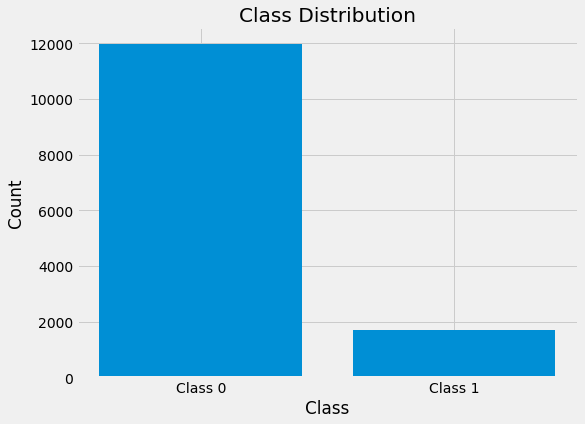

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('heg_sample_data.csv')
data = data.drop(columns=['Unnamed: 0'], errors='ignore')

x=data.drop(["outcome"],axis=1)
y=data["outcome"]

count_class = y.value_counts() # Count the occurrences of each class
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Class 0', 'Class 1'])
plt.show()

In [9]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(sampling_strategy='minority', random_state = 2025, k_neighbors = 3) 
x,y=smote.fit_resample(x,y)
y.value_counts()

outcome
0.0    11970
1.0    11970
Name: count, dtype: int64

In [10]:
total_dataset = pd.concat([x,y], axis = 1)

total_dataset.head()

,days_from_entrance,age,document.sexo,UTI,delta_collect_timestamp_t-t1,delta_collect_timestamp_t1-t2,delta_collect_timestamp_t2-t3,delta_collect_timestamp_t3-t4,document.freq_cardiaca(t),document.freq_cardiaca(t-1),...,delta_document.pa_sistolica_t3-t4,delta_document.sat_o2_t-t1,delta_document.sat_o2_t1-t2,delta_document.sat_o2_t2-t3,delta_document.sat_o2_t3-t4,delta_document.temperatura_t-t1,delta_document.temperatura_t1-t2,delta_document.temperatura_t2-t3,delta_document.temperatura_t3-t4,outcome
0,0.481160,-0.430375,1.0,0.0,0.181480,0.282895,0.397339,0.387741,-0.130331,0.337252,...,0.107772,0.202479,0.194332,0.432788,0.012866,-0.144525,-0.024481,0.152412,0.007067,0.0
1,1.837695,0.230175,1.0,0.0,1.201338,1.826415,1.625187,2.170093,1.451289,1.601233,...,-0.021933,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,0.0
2,0.226810,-0.719366,1.0,0.0,2.049497,4.031576,1.846655,2.285346,0.301020,0.403377,...,0.139667,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,0.0
3,-0.366674,1.716413,1.0,0.0,1.038056,0.686616,1.107306,0.877358,0.684443,0.823398,...,-0.101163,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,0.0
4,-0.366674,1.262285,0.0,0.0,0.879474,0.416499,0.427891,0.405360,0.492732,-0.537812,...,-0.021933,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,1.0


In [11]:
total_dataset.to_csv("SMOTE_pre_train.csv", index = False)

### T-SMOTE

In [14]:
import T_SMOTE as ts
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
data = pd.read_csv('heg_sample_data.csv')
data = data.drop(columns=['Unnamed: 0'], errors='ignore')

# 데이터 분리
X = data.drop(columns=["outcome"], errors='ignore').values  # Features
y = data["outcome"].values  # Labels

In [ ]:
# Step 1: 데이터 슬라이스 분할
tMin, tMax = 0, 10  # 시간 범위 (적절히 설정)
nSlices = 5  # 슬라이스 개수
T = [list(range(len(X)))]  # 각 데이터 샘플의 시간 정보 (여기서는 임의로 설정)
bins, slice_lengths = ts.getNonUniformTimeSliceBins(T, tMin, tMax, nSlices)

# Step 2: 슬라이스별 데이터 분류
time_slices = ts.getRawTimeSlice(X, bins, nSlices)

# Step 3: 각 슬라이스에서 synthetic 데이터 생성
nPoints = 1000  # 각 슬라이스에서 생성할 synthetic 데이터 개수
nNeighbors = 3  # SMOTE에서 사용할 이웃 개수
synthetic_data = ts.generateTimePoints(time_slices, nPoints, nNeighbors)

# Step 4: 기존 데이터와 synthetic 데이터를 혼합
nFix = 0  # 고정된 특성의 개수 (필요시 설정)
X_augmented = ts.imputeMixed(X, bins, synthetic_data, nf=5, nb=5, nFix=nFix)

print("Augmented Data Shape:", X_augmented.shape)


In [ ]:
import numpy as np

# y (라벨)을 증강된 데이터에 맞게 생성
y_augmented = np.hstack((y, [1] * (len(X_augmented) - len(X))))

# 클래스 분포 확인
unique, counts = np.unique(y_augmented, return_counts=True)
print("Class Distribution After Augmentation:", dict(zip(unique, counts)))